# Detecting Algorithmically Generated Domains
AGD's are commonly used for temporary domains in malware. The following is a quick exploration in using ML to automatically detect an AGD.

In [186]:
import warnings
warnings.filterwarnings("ignore")

In [187]:
#grab the top 100k 'legit' websites
import pandas as pd
import tldextract

alexa_df = pd.read_csv('data/alexa_100k.csv', names=['rank','uri'], header=None, encoding='utf-8')

#pull out just the top level domain
def domain_extract(uri):
    ext = tldextract.extract(uri)
    if (not ext.suffix):
        return np.nan
    else:
        return ext.domain

alexa_df['domain'] = [ domain_extract(uri) for uri in alexa_df['uri']]
del alexa_df['rank']
del alexa_df['uri']

#drop null rows
alexa_df.dropna()
alexa_df.drop_duplicates()

#add label
alexa_df['label'] = 'valid'

alexa_df.head()

,domain,label
0,facebook,valid
1,google,valid
2,youtube,valid
3,yahoo,valid
4,baidu,valid


In [188]:
#shuffle data
alexa_df = alexa_df.sample(frac=1).reset_index(drop=True)

alexa_df.head()

,domain,label
0,bookmarkzine,valid
1,toei,valid
2,veryhotsex,valid
3,miel,valid
4,clubedeautores,valid


In [189]:
from sklearn.model_selection import train_test_split
import numpy as np

#set aside 20% of data as test
alexa_train, alexa_test = train_test_split(alexa_df, test_size=0.2, random_state=42)


In [190]:
#take in sample of algorithmically generated domains
dga_df = pd.read_csv('data/dga.txt', names=['raw'], header=None, encoding='utf-8')
dga_df['domain'] = dga_df.applymap(lambda x: x.split('.')[0].strip().lower())
del dga_df['raw']
dga_df['label'] = 'dga'

#set aside 20% of data as test
dga_train, dga_test = train_test_split(dga_df, test_size=0.2, random_state=42)

dga_df.head()

,domain,label
0,04055051be412eea5a61b7da8438be3d,dga
1,1cb8a5f36f,dga
2,30acd347397c34fc273e996b22951002,dga
3,336c986a284e2b3bc0f69f949cb437cb,dga
4,336c986a284e2b3bc0f69f949cb437cb,dga


In [191]:
#combine the frames
df = pd.concat([alexa_df, dga_df], ignore_index=True)
df.head()

,domain,label
0,bookmarkzine,valid
1,toei,valid
2,veryhotsex,valid
3,miel,valid
4,clubedeautores,valid


In [192]:
df['domain'] = df['domain'].astype('|S')
df['length'] = [len(x) for x in df['domain']]

df.head()

,domain,label,length
0,b'bookmarkzine',valid,12
1,b'toei',valid,4
2,b'veryhotsex',valid,10
3,b'miel',valid,4
4,b'clubedeautores',valid,14


In [193]:
#compute the entropy of each string based on char frequency
import math
from collections import Counter
 
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

In [194]:
#add an entropy field
df['entropy'] = [entropy(x) for x in df['domain']]

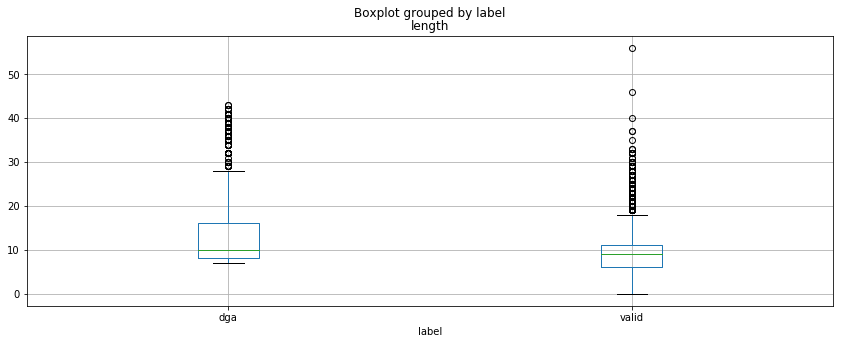

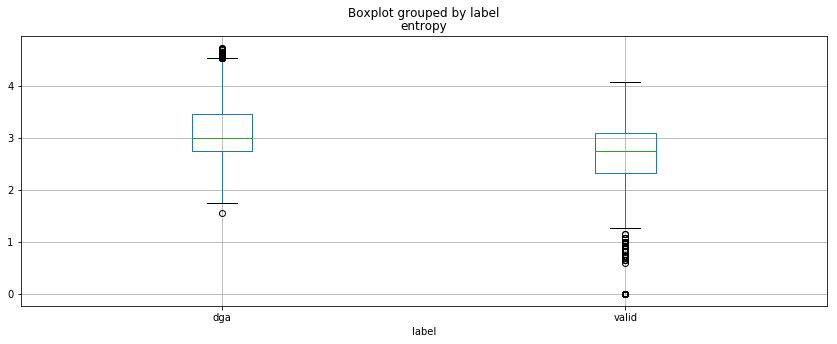

In [195]:
#plot out the differences
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14.0, 5.0)
plt.rcParams['axes.grid'] = True

#look for differences between valid and invalid
df.boxplot('length','label')
df.boxplot('entropy','label')



In [196]:
#we see high entropy is correlated to DGA
high_entropy = df[df['entropy']> 4]
high_entropy_dga = high_entropy[high_entropy['label']=='dga']
high_entropy_valid = high_entropy[high_entropy['label']=='valid']

print (len(high_entropy_dga))
print (len(high_entropy_valid))

363
3


In [197]:
high_entropy_dga.head()

,domain,label,length,entropy
100023,b'a17btkyb38gxe41pwd50nxmzjxiwjwdwfrp52',dga,37,4.540402
100024,b'a17c49l68ntkqnuhvkrmyb28fubvn30e31g43dq',dga,39,4.631305
100025,b'a17d60gtnxk47gskti15izhvlviyksh64nqkz',dga,37,4.270132
100026,b'a17erpzfzh64c69csi35bqgvp52drita67jzmy',dga,38,4.629249
100027,b'a17fro51oyk67b18ksfzoti55j36p32o11fvc29cr',dga,41,4.305859


In [198]:
high_entropy_valid.head()

,domain,label,length,entropy
17051,b'theukwebdesigncompany',valid,21,4.070656
51873,b'burzhunetdlyachaynikov',valid,22,4.004886
64918,b'congresomundialjjrperu2009',valid,26,4.056021


In [199]:
#lets try a random forrest classifer with the features of length and entropy
import sklearn.ensemble

X = df.as_matrix(['length', 'entropy'])
y = np.array(df['label'].tolist())

clf = sklearn.ensemble.RandomForestClassifier(n_estimators=20)

In [200]:
import sklearn.cross_validation

#how did we do?
scores = sklearn.cross_validation.cross_val_score(clf, X, y, cv=5, n_jobs=4)

print (scores)
clf.base_estimator

[0.97901042 0.97784163 0.97935132 0.97667284 0.97550285]


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')